In [1]:
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
import os
import torch
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from SNN import FeedForward, SiameseDataSet, SiameseModel, seed_everything
import seaborn as sns
import matplotlib.pyplot as plt   
import numpy as np
import random

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')
os.listdir(inp_dir)

['MatrixDataClean.csv', 'SampleMetaDataClean.csv', 'FeatMetaDataClean.csv']

In [3]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.head()

,6,study,Study No. (From VG sheet (V-*) from SB sheet (S-*)),Title of Paper,Author (year),Journal,Study Accession,Sample Accession or Sample ID,Sample title (ENA/SRA),Sample title (Paper),...,Use of milk or milk products (Yes/No/Sometimes),Use of Animal Product- Meat (Yes/No/Vegetarian/Vegan),Alcohol Consumption (Yes/No),Diet1,Intervention for study (Diet),Intervention for study (medication),Sequencing Platform,Library layout (SINGLE/PAIRED),Read count after Quality control,Healthy
0,SAMEA104142287,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142287,ZSL-004,ZSL-004,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,43356775.0,Unhealthy
1,SAMEA104142288,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142288,ZSL-007,ZSL-007,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,41073871.0,Unhealthy
2,SAMEA104142293,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142293,ZSL-010,ZSL-010,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,40199673.0,Unhealthy
3,SAMEA104142291,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142291,ZSL-011,ZSL-011,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,31054158.0,Unhealthy
4,SAMEA104142284,V-2_ACVD,V-2,The gut microbiome in atherosclerotic cardiova...,Jie (2017),Nature communications,PRJEB21528,SAMEA104142284,ZSL-019,ZSL-019,...,NaN,NaN,NaN,NaN,NaN,NaN,Illumina HiSeq 2000,PAIRED,36081150.0,Unhealthy


In [4]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'CRC', 'Crohns disease', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(3153, 34)

In [5]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData = MatrixData[filter_indices, :]
MatrixData.shape

(3153, 903)

In [6]:
X = MatrixData

In [7]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'))
FeatMeta

,Unnamed: 0,feature
0,s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
1,s__Acetobacter_unclassified,s__Acetobacter_unclassified
2,s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
3,s__Achromobacter_unclassified,s__Achromobacter_unclassified
4,s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...,...
898,s__Weissella_koreensis,s__Weissella_koreensis
899,s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
900,s__Weissella_unclassified,s__Weissella_unclassified
901,s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [8]:
SampleMeta['Phenotype'].value_counts()

Healthy           2636
CRC                257
ACVD               152
Crohns disease     108
Name: Phenotype, dtype: int64

In [9]:
y = SampleMeta['Phenotype'].to_numpy()

In [10]:
y

array(['ACVD', 'ACVD', 'ACVD', ..., 'Healthy', 'Healthy', 'Healthy'],
      dtype=object)

In [11]:
OneHot = OneHotEncoder(sparse=False)
y = OneHot.fit_transform(y.reshape((y.shape[0], 1)))

In [12]:
class_map = OneHot.transform(np.array(['ACVD', 'CRC', 'Crohns disease', 'Healthy']).reshape((4, 1)))

In [13]:
# One-hot encoded classes
class_map

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [14]:
# reverse mapping back to original classes
OneHot.inverse_transform(class_map)

array([['ACVD'],
       ['CRC'],
       ['Crohns disease'],
       ['Healthy']], dtype=object)

In [15]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [16]:
y.shape

(3153, 4)

In [17]:
np.sum(y, axis=0)

array([ 152.,  257.,  108., 2636.])

In [18]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

# Quick PCA of Data

In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
pca_model = PCA(n_components = None)
X_PCA = pca_model.fit_transform(X_scaled)

<AxesSubplot:>

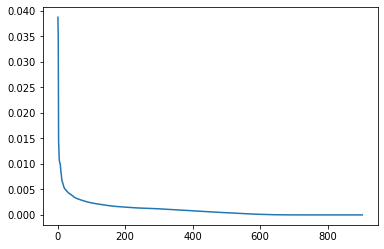

In [21]:
sns.lineplot(x = np.arange(1, len(pca_model.explained_variance_ratio_) + 1), y = pca_model.explained_variance_ratio_)

<AxesSubplot:>

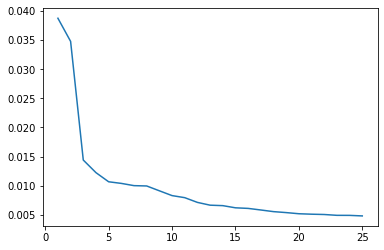

In [22]:
sns.lineplot(x = np.arange(1, 26), y = pca_model.explained_variance_ratio_[np.arange(0,25)])

<AxesSubplot:>

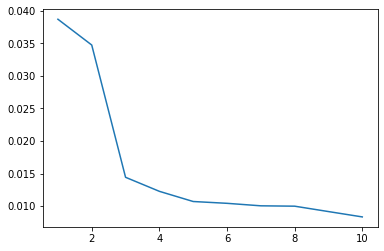

In [23]:
sns.lineplot(x = np.arange(1, 11), y = pca_model.explained_variance_ratio_[np.arange(0,10)])

# Define and Train Model

In [24]:
seed_everything(69)

In [25]:
MyFeedForward = FeedForward(5, [5, 5, 3, 3, 3], activation='softplus')

In [26]:
MyFeedForward

FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=3, bias=True)
    (3): Linear(in_features=3, out_features=3, bias=True)
    (4): Linear(in_features=3, out_features=3, bias=True)
  )
)

In [27]:
MySNN = SiameseModel(MyFeedForward, predict_unknown = False, class_min_train=5, 
                     n_example_predict=30, learning_rate=1.0e-2, num_epochs = 50, batch_size = 200, rand_seed=69)

In [28]:
# list(MySNN.logistic.parameters()) + list(MySNN.model.parameters())

In [29]:
MyTrainer = Trainer(model = MySNN, scale_X = True, use_pca = True, n_components = 5)

In [30]:
MyTrainTester = TrainTester(MyTrainer, metrics.accuracy_score)

In [31]:
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, n_splits=n_splits)

In [32]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Training Encoder
#########################################
Epoch 1 of 50
__Training__
2021-03-10 02:24:37
MEAN LOSS: 0.6243920490264893
__Validation__
2021-03-10 02:24:38
MEAN LOSS: 0.6045558999831563
#########################################
Epoch 2 of 50
__Training__
2021-03-10 02:24:38
MEAN LOSS: 0.5973541923522949
__Validation__
2021-03-10 02:24:39
MEAN LOSS: 0.6024571692589487
#########################################
Epoch 3 of 50
__Training__
2021-03-10 02:24:39
MEAN LOSS: 0.5968209266662597
__Validation__
2021-03-10 02:24:39
MEAN LOSS: 0.6023513534710709
#########################################
Epoch 4 of 50
__Training__
2021-03-10 02:24:39
MEAN LOSS: 0.5965790111541748
__Validation__
2021-03-10 02:24:40
MEAN LOSS: 0.6021975771357195
#########################################
Epoch 5 of 50
__Training__
2021-03-10 02:24:40
MEAN LOSS: 0.59644381980896
__Validation__
2021-03-10 02:24:41
MEAN LOSS: 0.6019761354187176
########################################

MEAN LOSS: 0.5848676342010498
__Validation__
2021-03-10 02:25:07
MEAN LOSS: 0.5994236780436162
#########################################
Epoch 46 of 50
__Training__
2021-03-10 02:25:07
MEAN LOSS: 0.5841845024108887
__Validation__
2021-03-10 02:25:07
MEAN LOSS: 0.5971147565558406
#########################################
Epoch 47 of 50
__Training__
2021-03-10 02:25:07
MEAN LOSS: 0.5840120182037354
__Validation__
2021-03-10 02:25:08
MEAN LOSS: 0.5977123373805886
#########################################
Epoch 48 of 50
__Training__
2021-03-10 02:25:08
MEAN LOSS: 0.5842079601287842
__Validation__
2021-03-10 02:25:09
MEAN LOSS: 0.5975657972959009
#########################################
Epoch 49 of 50
__Training__
2021-03-10 02:25:09
MEAN LOSS: 0.5839430828094483
__Validation__
2021-03-10 02:25:09
MEAN LOSS: 0.597112150046334
#########################################
Epoch 50 of 50
__Training__
2021-03-10 02:25:09
MEAN LOSS: 0.583715231704712
__Validation__
2021-03-10 02:25:10
MEAN LOSS: 0

MEAN LOSS: 0.5215330276489257
__Validation__
2021-03-10 02:25:39
MEAN LOSS: 0.5171335333644753
#########################################
Epoch 40 of 50
__Training__
2021-03-10 02:25:39
MEAN LOSS: 0.521063754272461
__Validation__
2021-03-10 02:25:40
MEAN LOSS: 0.5175145846245849
#########################################
Epoch 41 of 50
__Training__
2021-03-10 02:25:40
MEAN LOSS: 0.5208287673950195
__Validation__
2021-03-10 02:25:40
MEAN LOSS: 0.5169611423537068
#########################################
Epoch 42 of 50
__Training__
2021-03-10 02:25:40
MEAN LOSS: 0.5207421199798584
__Validation__
2021-03-10 02:25:41
MEAN LOSS: 0.5173513187576693
#########################################
Epoch 43 of 50
__Training__
2021-03-10 02:25:41
MEAN LOSS: 0.5204166042327881
__Validation__
2021-03-10 02:25:42
MEAN LOSS: 0.5174632042404985
#########################################
Epoch 44 of 50
__Training__
2021-03-10 02:25:42
MEAN LOSS: 0.5202865085601807
__Validation__
2021-03-10 02:25:42
MEAN LOSS: 

MEAN LOSS: 0.5832033557891846
__Validation__
2021-03-10 02:26:11
MEAN LOSS: 0.6002014900090779
#########################################
Epoch 34 of 50
__Training__
2021-03-10 02:26:11
MEAN LOSS: 0.583093009185791
__Validation__
2021-03-10 02:26:12
MEAN LOSS: 0.6010014987227941
#########################################
Epoch 35 of 50
__Training__
2021-03-10 02:26:12
MEAN LOSS: 0.5830531330108643
__Validation__
2021-03-10 02:26:12
MEAN LOSS: 0.5993689928475422
#########################################
Epoch 36 of 50
__Training__
2021-03-10 02:26:12
MEAN LOSS: 0.5833700668334961
__Validation__
2021-03-10 02:26:13
MEAN LOSS: 0.6002690978784158
#########################################
Epoch 37 of 50
__Training__
2021-03-10 02:26:13
MEAN LOSS: 0.5826802158355713
__Validation__
2021-03-10 02:26:14
MEAN LOSS: 0.5990870297223356
#########################################
Epoch 38 of 50
__Training__
2021-03-10 02:26:14
MEAN LOSS: 0.5829321029663086
__Validation__
2021-03-10 02:26:14
MEAN LOSS: 

MEAN LOSS: 0.5363688091278076
__Validation__
2021-03-10 02:26:43
MEAN LOSS: 0.5806017166638997
#########################################
Epoch 28 of 50
__Training__
2021-03-10 02:26:43
MEAN LOSS: 0.5357551486968994
__Validation__
2021-03-10 02:26:44
MEAN LOSS: 0.5812722351184093
#########################################
Epoch 29 of 50
__Training__
2021-03-10 02:26:44
MEAN LOSS: 0.535569478225708
__Validation__
2021-03-10 02:26:44
MEAN LOSS: 0.5808245644281835
#########################################
Epoch 30 of 50
__Training__
2021-03-10 02:26:44
MEAN LOSS: 0.5353330757141114
__Validation__
2021-03-10 02:26:45
MEAN LOSS: 0.5798619349296837
#########################################
Epoch 31 of 50
__Training__
2021-03-10 02:26:45
MEAN LOSS: 0.53483125
__Validation__
2021-03-10 02:26:45
MEAN LOSS: 0.5794146998737655
#########################################
Epoch 32 of 50
__Training__
2021-03-10 02:26:46
MEAN LOSS: 0.5344058166503907
__Validation__
2021-03-10 02:26:46
MEAN LOSS: 0.578452

MEAN LOSS: 0.5203965183258057
__Validation__
2021-03-10 02:27:15
MEAN LOSS: 0.5725759116515289
#########################################
Epoch 22 of 50
__Training__
2021-03-10 02:27:15
MEAN LOSS: 0.5200117473602295
__Validation__
2021-03-10 02:27:15
MEAN LOSS: 0.5760307303427792
#########################################
Epoch 23 of 50
__Training__
2021-03-10 02:27:16
MEAN LOSS: 0.5186949737548828
__Validation__
2021-03-10 02:27:16
MEAN LOSS: 0.5818079318365034
#########################################
Epoch 24 of 50
__Training__
2021-03-10 02:27:16
MEAN LOSS: 0.5183407325744629
__Validation__
2021-03-10 02:27:17
MEAN LOSS: 0.5787195983392285
#########################################
Epoch 25 of 50
__Training__
2021-03-10 02:27:17
MEAN LOSS: 0.5174415481567383
__Validation__
2021-03-10 02:27:17
MEAN LOSS: 0.5793061895911271
#########################################
Epoch 26 of 50
__Training__
2021-03-10 02:27:17
MEAN LOSS: 0.5170774642944336
__Validation__
2021-03-10 02:27:18
MEAN LOSS:

In [33]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.682395,train
1,0.809278,train
2,0.517446,train
3,0.812054,train
4,0.702617,train
0,0.664025,test
1,0.795563,test
2,0.505547,test
3,0.806656,test
4,0.694136,test


<AxesSubplot:xlabel='stage', ylabel='score'>

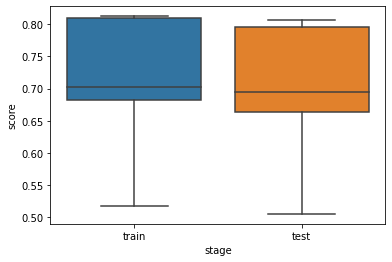

In [34]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

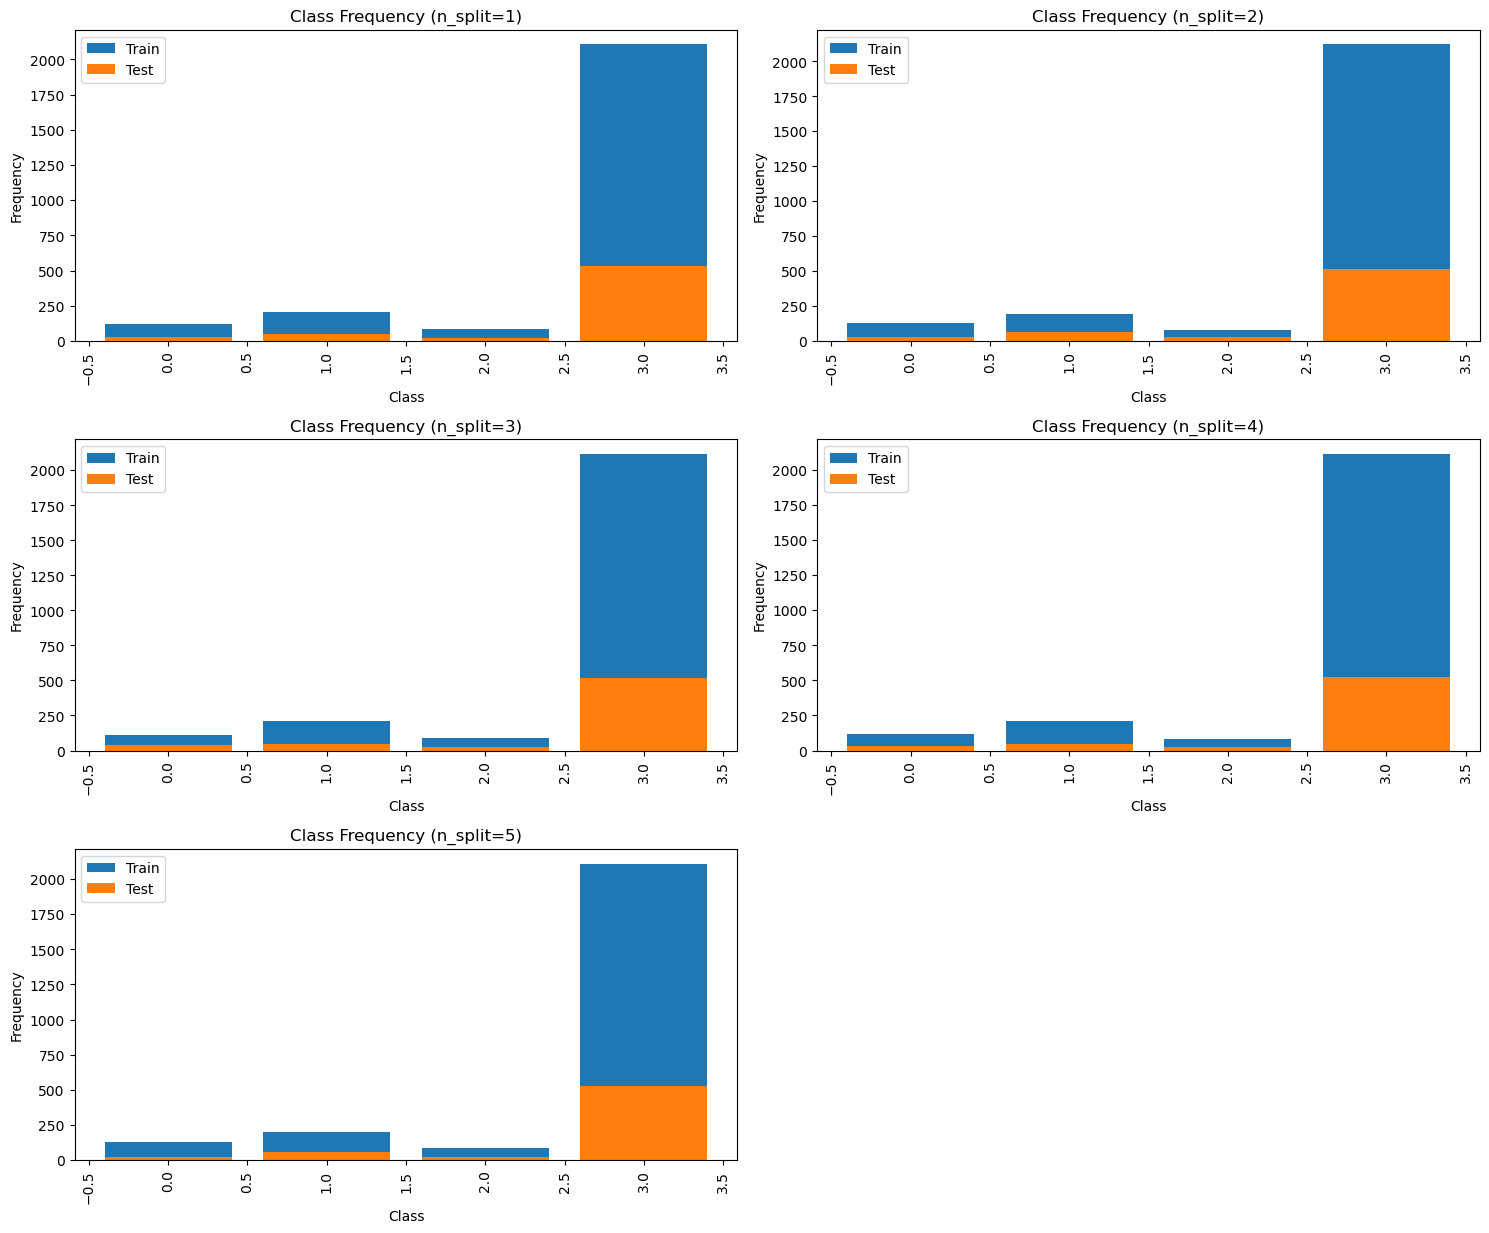

In [35]:
MyMultiTrainTester.plot_class_freq(normalize=True)

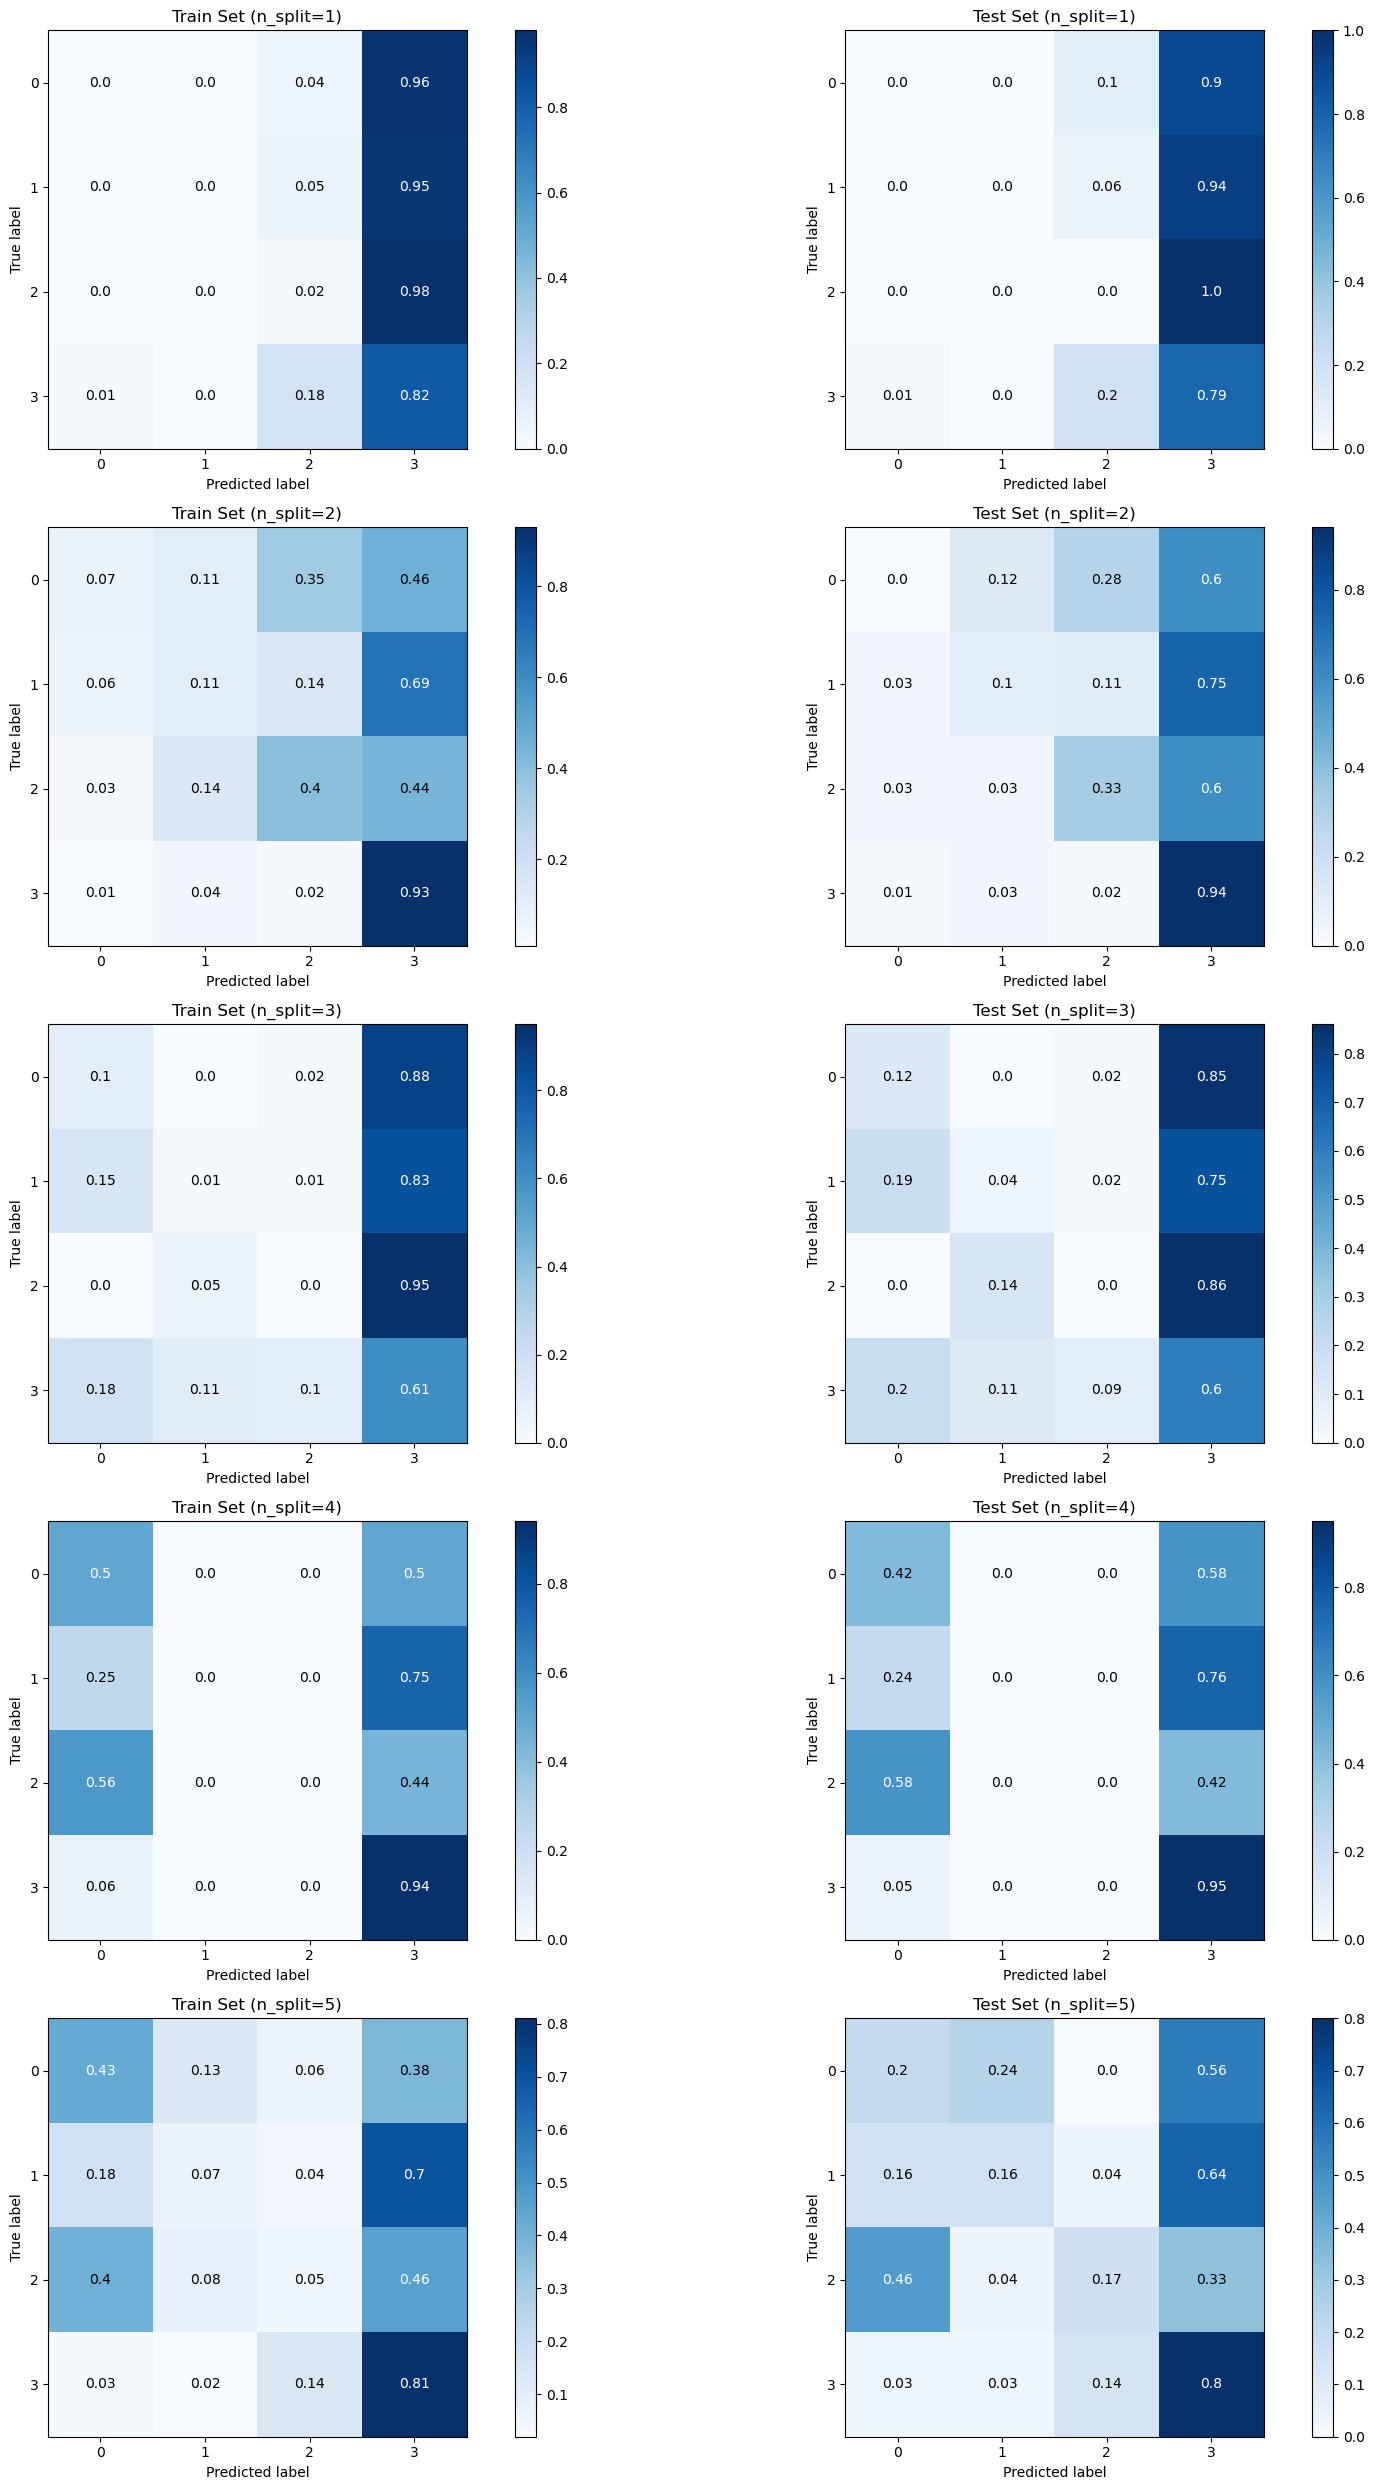

In [36]:
MyMultiTrainTester.plot_confusion(normalize=True)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


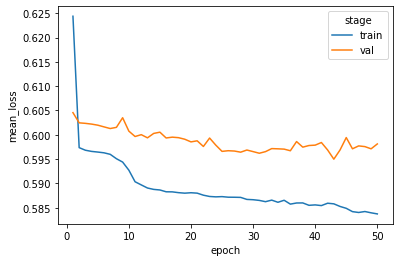

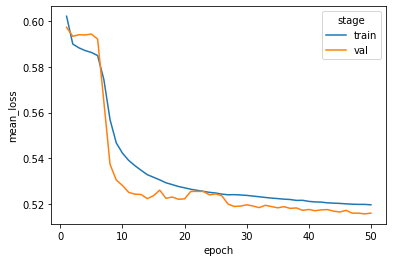

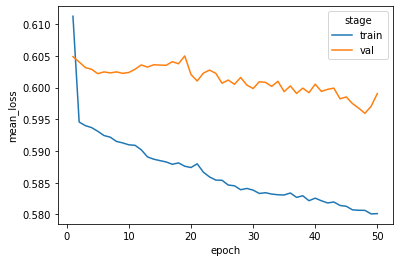

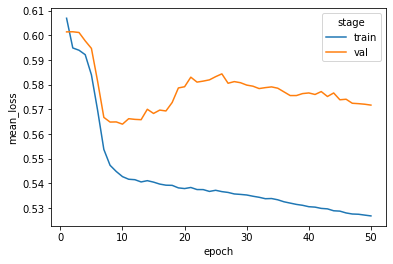

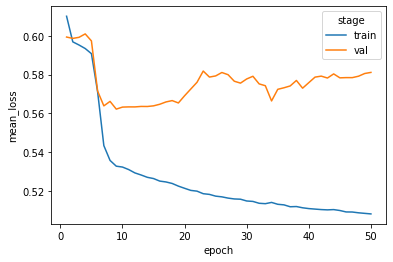

In [37]:
for i, trainer in enumerate(MyMultiTrainTester.TrainerList):
    plt.figure(i)
    print(sns.lineplot(data=trainer.model.TrainStats, x='epoch', y='mean_loss', hue = 'stage'))

### Examine Data In Encoded Space

In [38]:
best_model = np.argmax(MyMultiTrainTester.test_scores)
best_model

3

In [39]:
Trainer_use = MyMultiTrainTester.TrainerList[best_model]

In [40]:
X_transform = Trainer_use.transform_X(X)

In [41]:
X_encoded = Trainer_use.model.model.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [42]:
# X_encoded = MyFeedForward.forward(torch.from_numpy(X_transform).to(torch.float32)).detach().numpy()

In [43]:
X_encoded.shape

(3153, 3)

In [44]:
y_label = Trainer_use.model.one_hot.inverse_transform(y).astype('str')
y_pred = Trainer_use.model.predict(X_transform)
y_pred = Trainer_use.model.one_hot.inverse_transform(y_pred).astype('str')

In [45]:
X_enc_df = pd.DataFrame(X_encoded, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
X_enc_df['y'] = y_label
X_enc_df['y_pred'] = y_pred

In [46]:
X_enc_df

,X1,X2,X3,y,y_pred
0,6.721225,1.195638,2.775415,0,0
1,9.121630,1.117921,2.914652,0,3
2,7.030449,1.181043,2.773178,0,0
3,7.238361,1.171984,2.773656,0,0
4,8.255960,1.138020,2.815576,0,3
...,...,...,...,...,...
3148,9.192000,1.155369,3.064273,3,3
3149,9.000874,1.121423,2.899568,3,3
3150,9.830323,1.111835,2.800399,3,3
3151,8.867806,1.156992,2.949360,3,3


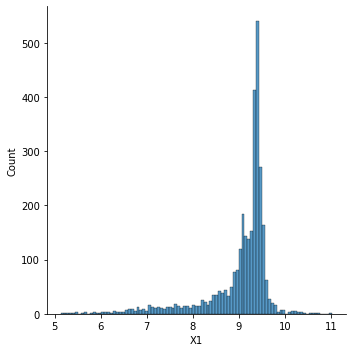

In [47]:
sns.displot(X_enc_df['X1'])

In [48]:
def do_plot(df, x, y, hue):
    if x in df.columns and y in df.columns and hue in df.columns:
        df_copy = df.copy(deep = True) 
        df_copy = df_copy.sort_values(by = hue)
        sns.scatterplot(data=df_copy, x=x, y=y, hue = hue)

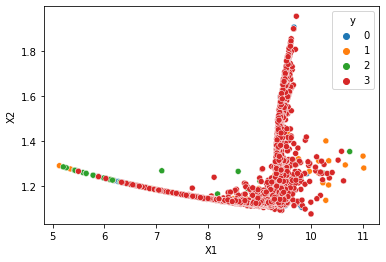

In [49]:
do_plot(X_enc_df, 'X1', 'X2', 'y')

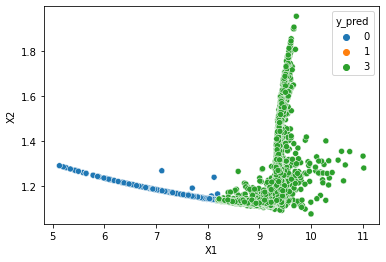

In [50]:
do_plot(X_enc_df, 'X1', 'X2', 'y_pred')

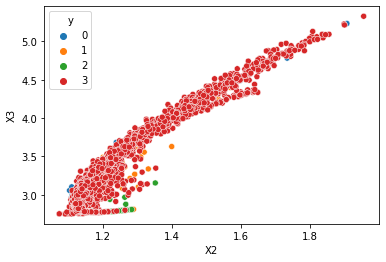

In [51]:
do_plot(X_enc_df, 'X2', 'X3', 'y')

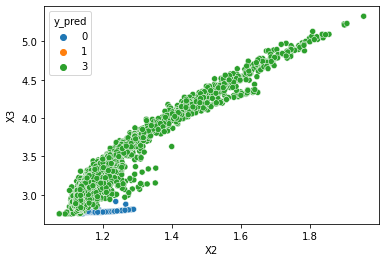

In [52]:
do_plot(X_enc_df, 'X2', 'X3', 'y_pred')

In [53]:
do_plot(X_enc_df, 'X3', 'X4', 'y')

### Examine Misclassified Samples, or first sample if no misclassified samples

If no misclassified samples, show correcly classified sample

In [54]:
X_db = Trainer_use.model.ClassDB['X_encoded'].detach().numpy()
X_db.shape

(120, 3)

In [55]:
class_map

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [56]:
OneHot.inverse_transform(class_map)

array([['ACVD'],
       ['CRC'],
       ['Crohns disease'],
       ['Healthy']], dtype=object)

In [57]:
y_db = Trainer_use.model.ClassDB['y'].detach().numpy()
y_db = OneHot.inverse_transform(y_db).astype('str').flatten()

In [58]:
db_df = pd.DataFrame(X_db, columns = ['X' + str(i+1) for i in range(X_encoded.shape[1])])
db_df['y'] = y_db

In [59]:
db_df['y'].value_counts()

Crohns disease    30
CRC               30
Healthy           30
ACVD              30
Name: y, dtype: int64

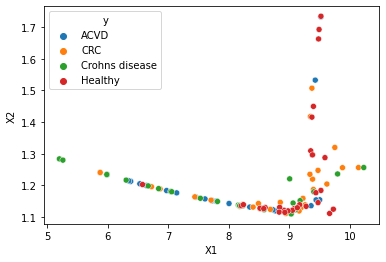

In [60]:
do_plot(db_df, 'X1', 'X2', 'y')

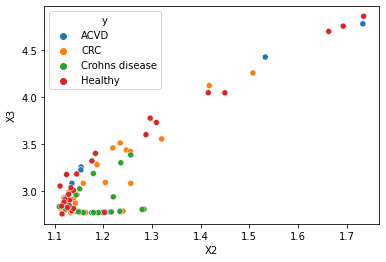

In [61]:
do_plot(db_df, 'X2', 'X3', 'y')

In [62]:
X_enc_df['misclassified'] = X_enc_df['y'] != X_enc_df['y_pred']

In [63]:
X_enc_df

,X1,X2,X3,y,y_pred,misclassified
0,6.721225,1.195638,2.775415,0,0,False
1,9.121630,1.117921,2.914652,0,3,True
2,7.030449,1.181043,2.773178,0,0,False
3,7.238361,1.171984,2.773656,0,0,False
4,8.255960,1.138020,2.815576,0,3,True
...,...,...,...,...,...,...
3148,9.192000,1.155369,3.064273,3,3,False
3149,9.000874,1.121423,2.899568,3,3,False
3150,9.830323,1.111835,2.800399,3,3,False
3151,8.867806,1.156992,2.949360,3,3,False


In [64]:
misclassified_idx = np.argwhere(X_enc_df['misclassified'].to_numpy()).flatten()
misclassified_idx

array([   1,    4,    5,    6,    9,   11,   13,   15,   17,   20,   22,
         25,   26,   27,   30,   33,   35,   36,   39,   44,   47,   52,
         53,   54,   55,   56,   58,   59,   60,   61,   63,   64,   65,
         66,   69,   70,   71,   73,   76,   80,   81,   82,   84,   88,
         92,   93,   96,   99,  101,  102,  103,  106,  107,  108,  109,
        110,  112,  115,  116,  117,  119,  120,  121,  125,  127,  128,
        129,  132,  133,  134,  135,  137,  139,  141,  144,  145,  146,
        147,  152,  153,  154,  155,  156,  157,  158,  159,  160,  161,
        162,  163,  164,  165,  166,  167,  168,  169,  170,  171,  172,
        173,  174,  175,  176,  177,  178,  179,  180,  181,  182,  183,
        184,  185,  186,  187,  188,  189,  190,  191,  192,  193,  194,
        195,  196,  197,  198,  199,  200,  201,  202,  203,  204,  205,
        206,  207,  208,  209,  210,  211,  212,  213,  214,  215,  216,
        217,  218,  219,  220,  221,  222,  223,  2

In [65]:
if len(misclassified_idx) == 0:
    idx_use = 0
else:
    idx_use = misclassified_idx[0]
    
X_diff = torch.abs(torch.from_numpy(X_encoded[idx_use, :] - X_db).to(torch.float32))
logistic_output = Trainer_use.model.logistic.forward(X_diff)

In [66]:
X_diff_df = pd.DataFrame(X_diff, columns = ['X' + str(i+1) + '_diff' for i in range(X_diff.shape[1])])
X_diff_df['y'] = y_db

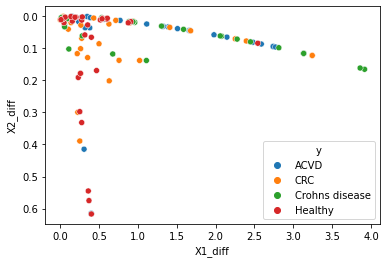

In [67]:
do_plot(X_diff_df, 'X1_diff', 'X2_diff', 'y')

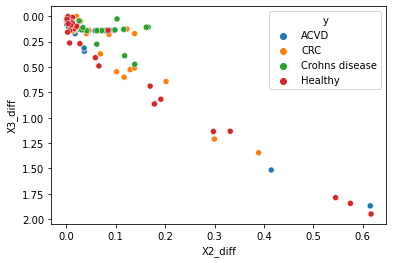

In [68]:
do_plot(X_diff_df, 'X2_diff', 'X3_diff', 'y')

In [69]:
logistic_output[y_db == 'Healthy', 1]

tensor([0.7835, 0.7084, 0.7126, 0.7109, 0.8093, 0.7691, 0.7132, 0.7561, 0.7750,
        0.6948, 0.7958, 0.6280, 0.7895, 0.7851, 0.7734, 0.8041, 0.8633, 0.8381,
        0.8266, 0.8661, 0.7653, 0.8030, 0.8262, 0.2160, 0.8058, 0.8430, 0.8648,
        0.6224, 0.7759, 0.7793], grad_fn=<IndexBackward>)

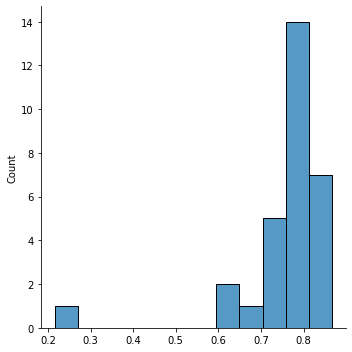

In [70]:
sns.displot(logistic_output[y_db == 'Healthy', 1].detach().numpy())

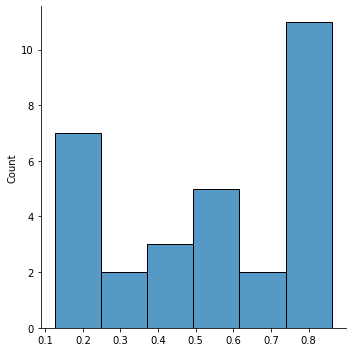

In [71]:
sns.displot(logistic_output[y_db == 'ACVD', 1].detach().numpy())

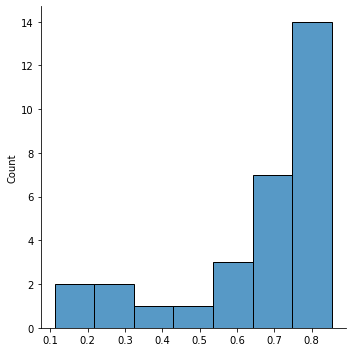

In [72]:
sns.displot(logistic_output[y_db == 'CRC', 1].detach().numpy())

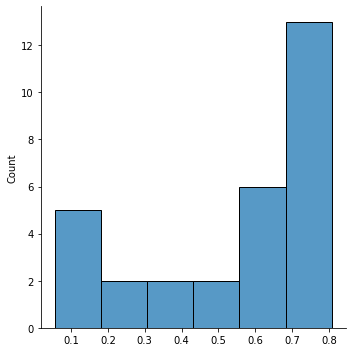

In [73]:
sns.displot(logistic_output[y_db == 'Crohns disease', 1].detach().numpy())

Overall, it appears that we aren't really learning much of a distance metric between classes. It may do well to try and balance classes represented in training stage